### LSA and Feature Engineering

In this notebook, I really tried to do as much features extraction as possible. The "processing and modeling" notebook, is where I ran my first model. In this notebook I'm really trying to go back through my pipeline and focus on creating features that may or may not give me some kind of signal as to whether an order belongs to a returning customer or not. I also tried alittle bit of clustering at the end but realized that might need another project.

In [1]:
import shopify
import requests
import re
import json
import pandas as pd
from pandas.io.json import json_normalize
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from urlparse import urlparse
import datetime as dt
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

### Load Pre - Processed Data

In [2]:
orders_df = pd.read_csv('orders_products.csv')
orders_df.drop_duplicates(inplace=True)

/Users/zober/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,34,64,67,83,122,126) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create New Target

I was concerned that orders where the customer bought mutliple products their first time was helping the model cheat a little bit. So I redifine my targethere to only look at the minimum values of those products (e.g. minimum weight, minimum price).

In [4]:


orders_df['customer.id'] = orders_df['customer.id'].astype('int')
orders_df['order_date'] = pd.to_datetime(orders_df['created_at'])
target_df = orders_df.groupby(['customer.id']).agg({'order_date': ['min', 'nunique']}).reset_index()

target_df['target'] = target_df['order_date']['nunique'] > 1
target_df.columns = target_df.columns.get_level_values(1)
target_df['customer.id'] = target_df.iloc[:,0]
target_df['target'] = target_df.iloc[:,3]
target_df = target_df[['customer.id', 'min', 'nunique', 'target']]
target_df.tail()

,customer.id,min,nunique,target
6182,5944946572,2017-03-20 22:59:24,1,False
6183,5945331724,2017-03-21 00:32:28,1,False
6184,5946224780,2017-03-21 03:39:14,1,False
6185,5953677900,2017-03-21 17:27:36,1,False
6186,5954703820,2017-03-21 17:53:59,1,False


In [5]:
# Looking at the distribution of our target
target_df.target.value_counts()

False    4659
True     1528
Name: target, dtype: int64

In [6]:
# Bring together features with newly defined target
orders_products = pd.merge(orders_df, target_df, left_on=['customer.id', 'order_date'], right_on=['customer.id','min'])

In [9]:
len(orders_products)

6875

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

### Engineering Time related Features

I used the customer-create date and product-create date, along with the month the Company was launched, to engineer some date features for my model. This includes the how long since the company started did they sign up, how long (in minutes) did it takeforthe customer to make their first purchase, and the month they purchased the order.

In [13]:
orders_products['days_till_signup'] = (pd.to_datetime(orders_products['customer.created_at']) - pd.datetime(2014, 11, 01)).dt.days

In [14]:
orders_products['seconds_to_purchase'] = (pd.to_datetime(orders_products['processed_at']) - pd.to_datetime(orders_products['customer.created_at'])).dt.seconds

In [15]:
orders_products['month_of_purchase'] = pd.to_datetime(orders_products['processed_at']).dt.month

Of all the 100 features from the three data sets, I now select the ones I want, plus the features I will later vectorize and use LSA on (items and message).

In [3]:
model_data = orders_products[['customer.id','buyer_accepts_marketing', 'payment_details.credit_card_company', 'referring_domain',
                       'total_price', 'total_weight', 'discount_type', 'device', 'shipping_meth', 'items', 'message',
                      'seconds_to_purchase', 'month_of_purchase', 'target']]

model_data.drop_duplicates(inplace=True)

In [17]:
model_data = model_data.fillna({'customer.id': 0,
                        'payment_details.credit_card_company': 'None',
                        'discount_type': 'None',
                        'referring_domain': 'None',
                        'seconds_to_purchase': 0,
                        'month_of_purchase': 0,
                        'message': 'None',
                        'items': 'None'
               })

model_data['shipping_meth'] = model_data['shipping_meth'].replace(['Free'], ['Other'])
model_data['seconds_to_purchase'] = model_data['seconds_to_purchase']//60

In [21]:
multi_orders = list(model_data.groupby('customer.id').filter(lambda x: len(x) > 1)['customer.id'].unique())

multiples = model_data[model_data['customer.id'].isin(multi_orders)]

features_clean = model_data[~model_data['customer.id'].isin(multi_orders)]

def row_concat(row):
    return "%s" % ', '.join(row)

multiples = multiples.groupby('customer.id', as_index=False).aggregate({'buyer_accepts_marketing': 'mean',
                                            'payment_details.credit_card_company': lambda x: x.value_counts().index[0],
                                            'referring_domain': lambda x: x.value_counts().index[0],
                                            'total_price': 'min',
                                            'total_weight': 'min',
                                            'seconds_to_purchase': 'min',
                                            'month_of_purchase': 'min',
                                            'discount_type': lambda x: x.value_counts().index[0],
                                            'device': lambda x: x.value_counts().index[0],
                                            'shipping_meth': lambda x: x.value_counts().index[0],
                                            'items': lambda x: row_concat(x),
                                            'message': lambda x: row_concat(x),
                                            'target': 'min'})

model_data = pd.concat([features_clean, multiples]).reset_index(drop=True)
model_data.head()

,buyer_accepts_marketing,customer.id,device,discount_type,items,message,month_of_purchase,payment_details.credit_card_company,referring_domain,seconds_to_purchase,shipping_meth,target,total_price,total_weight
0,False,5954703820,Mac,None,"Bling Wipes , Compartes , Drybar , HAY , ...",Hi mama! I love you and hope you're recovering...,3,Visa,Google,5.0,Postmates,False,117.93,2268
1,False,5953677900,Mac,None,"Compartes , Herbivore Botanicals , Rifle Pa...",Thank you Dr. DiNome for your expert hand and ...,3,Visa,Google,1.0,Postmates,False,96.73,2268
2,True,5946224780,Mac,None,"BillyKirk , Everyman Jack , Izola , Rock C...",Two years down and forever to go. You are my f...,3,Mastercard,Google,2.0,USPS,False,113.00,2268
3,False,5945331724,PC,None,"HAY , Mast Brothers , Voluspa",None,3,Visa,Google,10.0,USPS,False,41.00,2268
4,False,5941618124,Mac,None,"Elizabeth W , HAY , Le Pens , Le Pens , R...",Happy Birthday Constance!\n\nWe love you and a...,3,American Express,Other,370.0,USPS,False,105.62,2268


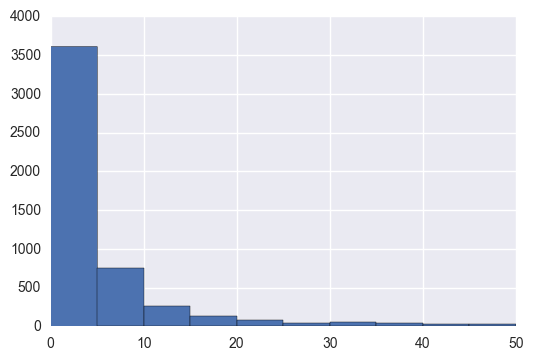

In [22]:
model_data['seconds_to_purchase'].hist(range=(0,50))

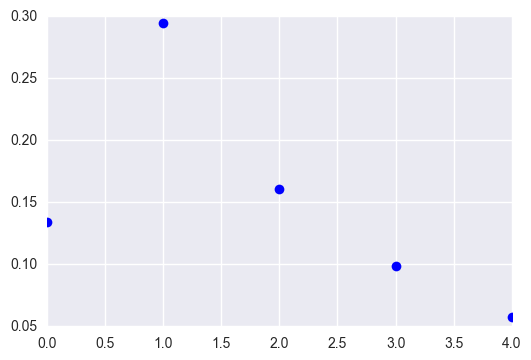

In [842]:
plt.plot(lsa.explained_variance_ratio_, 'bo')

In [26]:
features = model_data[['customer.id','buyer_accepts_marketing', 'payment_details.credit_card_company', 'referring_domain',
                       'total_price', 'total_weight', 'discount_type', 'device', 'shipping_meth', 'items', 'message',
                      'seconds_to_purchase', 'month_of_purchase']]

target = model_data['target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .3, random_state=42)

In [ ]:
def get_unique_items(series):
    items = []
    for row in series:
        if pd.isnull(row) == True:
            continue
        else:
            for r in row.split(','):
                items.append(r)
    return list(set(items))

items = get_unique_items(features['items'])
items = [i.strip(' ').lower() for i in items]
items = list(set(items))

In [29]:
mapper = DataFrameMapper([
        ('payment_details.credit_card_company', LabelBinarizer()),
        ('buyer_accepts_marketing', LabelBinarizer()),
        ('referring_domain', LabelBinarizer()),
        ('discount_type', LabelBinarizer()),
        ('device', LabelBinarizer()),
        ('shipping_meth', LabelBinarizer()),
        ('items', [TfidfVectorizer(vocabulary=items), TruncatedSVD(5)]),
        ('message', [TfidfVectorizer(vocabulary=items), TruncatedSVD(10)]),
        ('total_price', None),
        ('total_weight', None),
        ('seconds_to_purchase', None),
        ('month_of_purchase', None)
    ])

mapper2 = DataFrameMapper([
        ('payment_details.credit_card_company', LabelBinarizer()),
        ('buyer_accepts_marketing', LabelBinarizer()),
        ('referring_domain', LabelBinarizer()),
        ('discount_type', LabelBinarizer()),
        ('device', LabelBinarizer()),
        ('shipping_meth', LabelBinarizer()),
        ('items', [TfidfVectorizer(vocabulary=items), TruncatedSVD(5)]),
        ('message', [TfidfVectorizer(vocabulary=items), TruncatedSVD(10)]),
        ('total_price', None),
        ('total_weight', None),
        ('seconds_to_purchase', None),
        ('month_of_purchase', None)
    ], df_out=True)

In [30]:
mapper_df = mapper2.fit_transform(features)

In [31]:
pipe = Pipeline([
    ('featurize', mapper),
    ('rf', RandomForestClassifier(n_estimators=500, max_features='sqrt'))]
    )

In [32]:
pipe.fit(X_train, y_train.astype(int))

Pipeline(steps=[('featurize', DataFrameMapper(default=False, df_out=False,
        features=[('payment_details.credit_card_company', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('buyer_accepts_marketing', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('referring_domain',...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, precision_score, confusion_matrix

In [36]:
pred_prob = pipe.predict_proba(X_test)

In [37]:
prec, recall, thresh = precision_recall_curve(y_test, pred_prob[:,1])

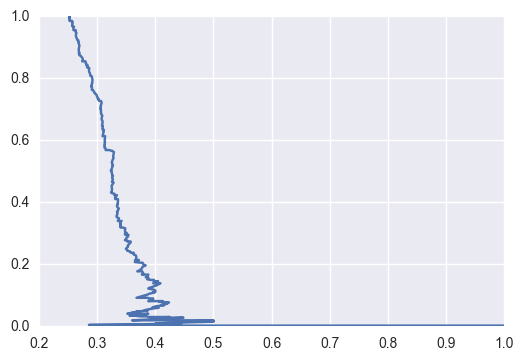

In [38]:
plt.plot(prec[0:-1], recall[0:-1])

In [567]:
API_KEY = ""
PASSWORD = ""
shop_url = "https://%s:%s@boxfox.myshopify.com/admin/" % (API_KEY, PASSWORD)
shopify.ShopifyResource.set_site(shop_url)

In [147]:
import ml_insights as mli

In [851]:
pred_prob[:,1][np.where(pred_prob[:,1] < .4)]

array([ 0.368,  0.116,  0.192, ...,  0.13 ,  0.288,  0.134])

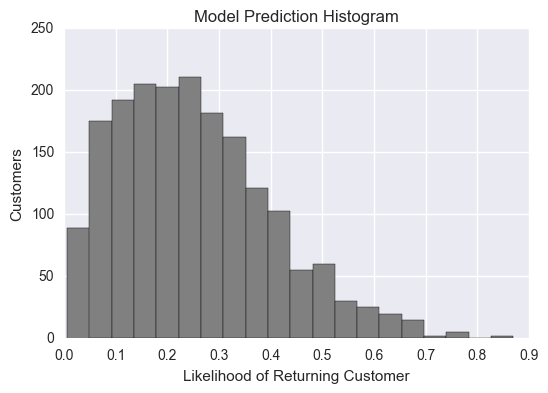

In [39]:
plt.hist(pred_prob[:, 1], bins = 20, color= 'grey')
plt.xlabel('Likelihood of Returning Customer')
plt.ylabel('Customers')
plt.ylim(0, 250)
plt.title('Model Prediction Histogram')

In [852]:

more = X_test.iloc[np.where(pred_prob[:,1] >= .40)]
less = X_test.iloc[np.where(pred_prob[:,1] < .10)]

In [143]:
100 * less['month_of_purchase'].value_counts()/len(less['month_of_purchase'])

12    32.518337
2     30.073350
1     22.004890
3     12.469438
11     2.933985
Name: month_of_purchase, dtype: float64

In [140]:
more['total_price'].mean()

74.95671140939594

In [128]:
print(less['total_price'].mean())
print(more['total_price'].mean())
print(features['total_price'].mean())

88.1205623472
74.9567114094
80.9769258122


In [297]:
model_data.loc[model_data['target'] == 1,
               'month_of_purchase'].value_counts() /model_data[model_data['target'] == 1].shape[0]

12    0.153796
11    0.103403
8     0.100785
2     0.100131
3     0.096204
7     0.080497
9     0.074607
4     0.072644
10    0.067408
5     0.056283
6     0.049738
1     0.044503
Name: month_of_purchase, dtype: float64

In [296]:
model_data.loc[model_data['target'] == 0,
               'month_of_purchase'].value_counts() / model_data[model_data['target'] == 0].shape[0]

12    0.156042
2     0.142734
3     0.101095
11    0.092724
1     0.091221
8     0.085855
9     0.076841
10    0.074694
4     0.055162
5     0.048508
7     0.047435
6     0.027688
Name: month_of_purchase, dtype: float64

In [290]:
len(features['month_of_purchase'])

6187

In [293]:
100 * more['month_of_purchase'].value_counts() / len(more['month_of_purchase'])

2     35.570470
12    28.859060
1     20.134228
3     12.080537
11     3.355705
Name: month_of_purchase, dtype: float64

In [292]:
100 * features['month_of_purchase'].value_counts() / len(features['month_of_purchase'])

12    15.548731
2     13.221270
3      9.988686
11     9.536124
8      8.954259
1      7.968321
9      7.628899
10     7.289478
4      5.947955
7      5.560045
5      5.042832
6      3.313399
Name: month_of_purchase, dtype: float64

In [787]:
X_test.head()

,customer.id,buyer_accepts_marketing,payment_details.credit_card_company,referring_domain,total_price,total_weight,discount_type,device,shipping_meth,items,message,seconds_to_purchase,month_of_purchase
5322,1506366403,False,Visa,Facebook,60.75,454,None,Mac,USPS,"Bling Wipes, Hammond's , Kate Spade , Le P...","Happy Birthday Mom, I made this box full of li...",2.0,10
926,5314869772,True,American Express,Google,70.50,454,percentage,PC,USPS,"Bling Wipes, Drybar , Le Pens , Rifle Pape...","Chelsie Belsie,\n\nHappy Happy Birthday, my si...",1179.0,1
893,5627233804,True,American Express,Other,40.00,454,shipping,Mac,USPS,None,None,2.0,1
5223,1715193411,False,Visa,BoxFox,61.15,454,None,PC,USPS,"Hammond's , Rose Macaron Limoge Trinket Tray...",take the time to celebrate you and everything ...,0.0,10
4410,2632123526,False,Visa,BoxFox,48.60,454,None,Mac,USPS,"Ginger Beer, Striped Straws , Sugarfina , ...","Matt & Erin,\n\nI must be living under a rock,...",1.0,3


(0, 200)

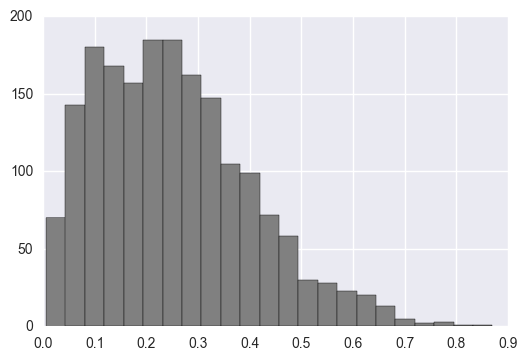

In [78]:
plt.hist(pred_prob[:,1], bins = 23, color = 'grey')
plt.ylim(0,200)

In [141]:
more = features.iloc[np.where(pred_prob[:,1] >= .486)[0]]
less = features.iloc[np.where(pred_prob[:,1] < .125)[0]]

In [303]:
returning_cust = model_data['target'] == 1
one_time_cust = model_data['target'] == 0

In [309]:
model_data.loc[returning_cust, 'total_price'].mean()

83.63443717277393

In [310]:
model_data.loc[one_time_cust, 'total_price'].mean()

80.10534878729536

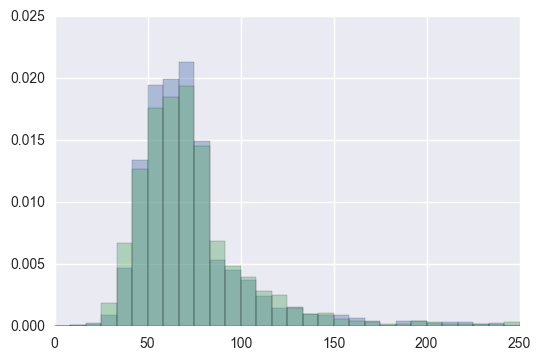

In [308]:
plt.hist(model_data.loc[returning_cust, 'total_price'], bins = 30, range = (0,250), alpha = .4,normed=True)
plt.hist(model_data.loc[one_time_cust, 'total_price'], bins = 30, range = (0,250), alpha = .4, normed=True);

In [142]:
more['total_price'].mean()

74.95671140939594

(0, 200)

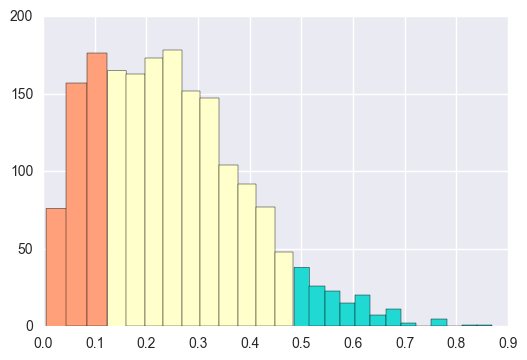

In [287]:
plt.hist(pred_prob[:,1][np.where(pred_prob[:,1] < .125)], bins=3, color = '#ffa07a')
plt.hist(pred_prob[:,1][np.where((pred_prob[:,1] < .486) & (pred_prob[:,1] >= .125))], bins=10, color='#FFFFCC')
plt.hist(pred_prob[:,1][np.where(pred_prob[:,1] >= .486)],bins= 13, color = '#20D9D3')
plt.ylim(0, 200)

In [68]:
from scipy.stats import percentileofscore
percentileofscore(pred_prob[:,1],  .486)

92.057081313947236

In [627]:
mxr = mli.ModelXRay(rfmod, mapper_df.sample(50), columns = ['referring_domain_Google', 'payment_details.credit_card_company_Visa', 'discount_type_None'])

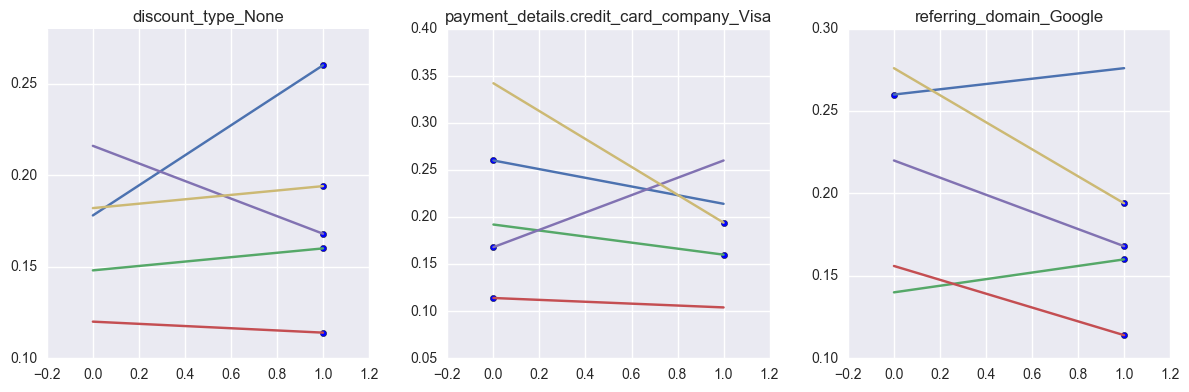

In [628]:
indices = mxr.feature_dependence_plots()

In [264]:
indices

array([ 1, 56, 90, 57, 84])

In [629]:
features.columns

Index([u'customer.id', u'buyer_accepts_marketing',
       u'payment_details.credit_card_company', u'referring_domain',
       u'total_price', u'total_weight', u'discount_type', u'device',
       u'shipping_meth', u'items', u'message', u'seconds_to_purchase',
       u'month_of_purchase'],
      dtype='object')

In [263]:
mapper_df.loc[indices,:]

,payment_details.credit_card_company_American Express,payment_details.credit_card_company_Discover,payment_details.credit_card_company_Mastercard,payment_details.credit_card_company_None,payment_details.credit_card_company_Visa,buyer_accepts_marketing,referring_domain_Bing,referring_domain_BoxFox,referring_domain_Facebook,referring_domain_Glitter Guide,...,items_9,message_0,message_1,message_2,message_3,message_4,total_price,total_weight,seconds_to_purchase,month_of_purchase
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.530276,0.0,0.0,0.0,0.0,0.0,0.139507,1.173888,-0.381177,-0.987272
56,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.156156,0.0,0.0,0.0,0.0,0.0,-0.154340,1.173888,-0.390154,-0.987272
90,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,-0.213228,1.173888,3.871016,-0.987272
57,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.156156,0.0,0.0,0.0,0.0,0.0,-0.154340,1.173888,-0.390154,-0.987272
84,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.010946,0.0,0.0,0.0,0.0,0.0,-0.402509,1.173888,1.016271,-0.987272


In [154]:
pd.Series(index=mapper_df.columns, data=pipe.steps[-1][1].feature_importances_).sort_values(ascending=False)

total_price                                             0.199479
seconds_to_purchase                                     0.150344
month_of_purchase                                       0.121787
items_4                                                 0.045686
items_3                                                 0.041900
items_2                                                 0.041442
items_1                                                 0.040780
items_0                                                 0.040776
buyer_accepts_marketing                                 0.031970
payment_details.credit_card_company_Visa                0.022560
device_PC                                               0.020277
device_Mac                                              0.019822
referring_domain_Google                                 0.019761
total_weight                                            0.018719
referring_domain_Other                                  0.017871
payment_details.credit_ca

In [87]:
100 * features['device'].value_counts()/len(features['device'])

Mac        70.534993
PC         28.042670
Android     1.099079
Other       0.323258
Name: device, dtype: float64

In [43]:
pr_df = pd.DataFrame({'threshhold': thresh, 'precision': prec[0:-1], 'recall': recall[0:-1]}).sort_values(by='precision',
            ascending=False)

In [44]:
pr_df[(pr_df['precision']>= .4)].head(30)

,precision,recall,threshhold
382,1.000000,0.002137,0.870000
381,0.500000,0.002137,0.830000
367,0.500000,0.019231,0.666000
369,0.500000,0.017094,0.672000
371,0.500000,0.014957,0.678000
368,0.470588,0.017094,0.668000
370,0.466667,0.014957,0.676000
372,0.461538,0.012821,0.682000
366,0.450000,0.019231,0.664000
359,0.448276,0.027778,0.632000


(array([291, 292, 295, 296, 297, 302, 303, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 333, 355, 356, 357, 358, 359,
        360, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 379,
        381, 382, 383]),)

In [45]:
pred = np.greater( pred_prob[:,1], .482)

print(recall_score(y_test, pred))
print(precision_score(y_test, pred))
print(accuracy_score(y_test, pred))

0.132478632479
0.402597402597
0.73182552504


In [134]:
X_test.shape

(2063, 12)

In [46]:
confusion_matrix(pred)

In [678]:
y_test.value_counts()

False    1389
True      468
Name: target, dtype: int64

In [680]:
468.0/(1389+468)

0.2520193861066236

In [150]:
rfmod = pipe.steps[1][1]

In [151]:
lsa = pipe.steps[0][1].features[6][1].steps[1][1]

tf = pipe.steps[0][1].features[6][1].steps[0][1]

In [ ]:
TOPIC 0 = candles, treats
TOPIC 1 = writing, pens, stationary, pics
TOPIC 2 = 0 and 1 

In [273]:


pd.DataFrame(lsa.components_, index=['topic_0','topic_1', 'topic_2', 'topic_3', 'topic_4'], columns = items).iloc[1,:].sort_values(ascending=False)

none                                             9.857006e-01
fuji                                             1.774869e-04
                                                 4.762404e-18
boss keychain                                    3.891315e-19
kate spade dot spiral notebook                   2.160320e-22
b. toffee                                        9.162323e-23
canvas home                                      7.823937e-23
on writing by stephen king                       4.270271e-27
le pens                                          0.000000e+00
nostrum                                          0.000000e+00
the beach people                                 0.000000e+00
hella slingshots                                 0.000000e+00
six depot roastery                               0.000000e+00
mast borthers                                    0.000000e+00
white & kalman                                   0.000000e+00
rustic bakery                                    0.000000e+00
rifle pa

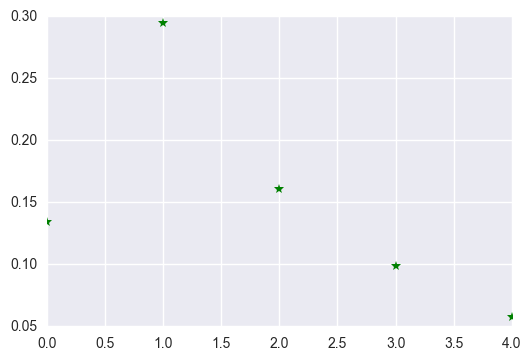

In [248]:
plt.plot(lsa.explained_variance_ratio_, 'g*')

In [152]:
words = np.array(tf.get_feature_names())
set_array = []
for row in lsa.components_:
    item_indices = np.argsort(row)[-50:]
    set_array.append(words[item_indices])

In [195]:
topics = []
for set_ in set_array:
    topics.append(set_[:10])

In [196]:
np.setdiff1d(topics[4], [topics[3], topics[2], topics[1], topics[0]])

array(['shorty olive oil', 'the beach people'], 
      dtype='|S45')

In [179]:
topics[:4]

[array(["mast brother's", 'earth + element', 'consider the wldflowers',
        'fashion mamas x boxfox', 'dry shampoo',
        'native union smart charger', 'carry on cocktail kit',
        'garden-in-a-bag basil', 'sea foam mug', 'reindeer bottle stopper'], 
       dtype='|S45'),
 array(['the social type', 'tea towel', 'yellow macaron trinket box',
        'rose macaron limoge trinket tray', "mast brother's", 'sleep mask',
        'love style life by garance dore',
        'white macaron limoge trinket box', 'native union',
        'crux supply co.'], 
       dtype='|S45'),
 array(['rose macaron limoge trinket tray', "mast brother's", 'sleep mask',
        'love style life by garance dore',
        'white macaron limoge trinket box', 'native union',
        'crux supply co.', 'deuce brand', 'hella slingshots',
        'six depot roastery'], 
       dtype='|S45'),
 array(['native union', "mast brother's", 'sleep mask', 'mast borthers',
        'white & kalman', 'six depot roastery', 

In [73]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

In [50]:
Kmod = KMeans()

In [94]:
norm = Normalizer()
scale = StandardScaler()

In [100]:
norm.transform(features['month_of_purchase'])

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.0045836 ,  0.0045836 ,  0.0045836 , ...,  0.01833442,
         0.01680655,  0.01680655]])

In [135]:
clust_mapper = DataFrameMapper([
        ('payment_details.credit_card_company', LabelBinarizer()),
        ('buyer_accepts_marketing', LabelBinarizer()),
        ('referring_domain', LabelBinarizer()),
        ('discount_type', LabelBinarizer()),
        ('device', LabelBinarizer()),
        ('shipping_meth', LabelBinarizer()),
        ('items', [TfidfVectorizer(vocabulary=items), TruncatedSVD(10)]),
        ('message', [TfidfVectorizer(vocabulary=items), TruncatedSVD(5)]),
        ('total_price', StandardScaler()),
        ('total_weight', StandardScaler()),
        ('seconds_to_purchase',  StandardScaler()),
        ('month_of_purchase', StandardScaler())
    ], df_out=True)

clust_mapper.fit_transform(features)

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anacon

,payment_details.credit_card_company_American Express,payment_details.credit_card_company_Discover,payment_details.credit_card_company_Mastercard,payment_details.credit_card_company_None,payment_details.credit_card_company_Visa,buyer_accepts_marketing,referring_domain_Bing,referring_domain_BoxFox,referring_domain_Facebook,referring_domain_Glitter Guide,...,items_9,message_0,message_1,message_2,message_3,message_4,total_price,total_weight,seconds_to_purchase,month_of_purchase
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.175320e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.139507,1.173888,-0.381177,-0.987272
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.175320e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.139507,1.173888,-0.381177,-0.987272
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-2.370823e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.038837,1.173888,-0.393147,-0.987272
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-2.370823e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.038837,1.173888,-0.393147,-0.987272
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.107890e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.098034,1.173888,-0.390154,-0.987272
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.107890e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.098034,1.173888,-0.390154,-0.987272
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-3.371229e-02,1.0,-1.073669e-17,-1.261514e-18,2.338048e-19,-4.086858e-21,-0.507665,1.173888,-0.366215,-0.987272
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-3.371229e-02,1.0,-1.073669e-17,-1.261514e-18,2.338048e-19,-4.086858e-21,-0.507665,1.173888,-0.366215,-0.987272
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.545437e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.035950,1.173888,0.711047,-0.987272
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.545437e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.035950,1.173888,0.711047,-0.987272


In [200]:
lsa

PandasError: DataFrame constructor not properly called!

In [137]:
pipe2 = Pipeline([
    ('featurize', clust_mapper),
    ('km', KMeans(n_clusters=3))]
    )

In [138]:
Normalizer

sklearn.preprocessing.data.Normalizer

In [139]:
features = features.fillna({'customer.id': 0,
                        'payment_details.credit_card_company': 'None',
                        'discount_type': 'None',
                        'referring_domain': 'None',
                        'seconds_to_purchase': 0,
                        'month_of_purchase': 0,
                        'message': 'None',
                        'items': 'None'
               })

pipe2.fit(features)

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anacon

Pipeline(steps=[('featurize', DataFrameMapper(default=False, df_out=True,
        features=[('payment_details.credit_card_company', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('buyer_accepts_marketing', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('referring_domain', ..._init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0))])

In [140]:
clust_1 = features[pipe2.steps[1][1].labels_==0]
clust_2 = features[pipe2.steps[1][1].labels_==1]
clust_3 = features[pipe2.steps[1][1].labels_==2]

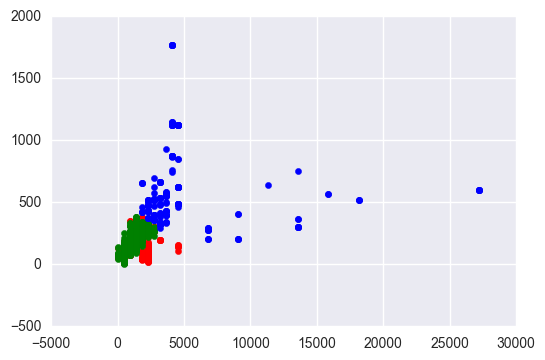

In [62]:
plt.scatter(clust_1.total_weight, clust_1.total_price, color = 'r')
plt.scatter(clust_2.total_weight, clust_2.total_price, color = 'g')
plt.scatter(clust_3.total_weight, clust_3.total_price, color = 'b')

In [64]:
clust_1.mean()

buyer_accepts_marketing      0.550388
total_price                 81.723434
total_weight               706.470172
seconds_to_purchase        128.483654
month_of_purchase            2.893832
dtype: float64

In [66]:
clust_2.mean()

buyer_accepts_marketing      0.507902
total_price                 86.197346
total_weight               573.322343
seconds_to_purchase        131.272207
month_of_purchase            9.986649
dtype: float64

In [67]:
clust_3.mean()

buyer_accepts_marketing       0.563025
total_price                 579.580840
total_weight               4932.399160
seconds_to_purchase         198.092437
month_of_purchase             8.042017
dtype: float64

In [72]:
pipe2.steps[1][1].sill`

39446.514860287374

In [141]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score()